In [ ]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# installing the keras tuner
# reference - https://www.youtube.com/watch?v=OzLAdpqm35E&t=704s
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.1 MB/s 
     |████████████████████████████████| 1.6 MB 30.6 MB/s 


In [ ]:
# import libraries
import tensorflow as tf
import timeit
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import time
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense
from keras.layers import Input
from keras.layers import GlobalMaxPooling1D
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Embedding
from keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import keras
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.offline as py
import plotly.express as px
from plotly import tools
import plotly.figure_factory as ff
import warnings
from matplotlib import pyplot as plt
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# unzip the dataset
import os
zip_path = os.path.join(os.path.join('drive', 'My Drive', 'Dissertation'), 'df_news_combined.csv.zip')
!cp '{zip_path}' .
!yes|unzip -q df_news_combined.csv.zip
!rm df_news_combined.csv.zip
print(os.listdir(os.path.join('drive', 'My Drive', 'Dissertation')))

['df_news_combined.csv.zip', 'trails.ipynb', 'naivebayes_base_and_tuned.ipynb', 'xgboost_base_and_tuned.ipynb', 'random_forest_base_and_tuned.ipynb', 'cnn_base_and_tuned.ipynb', 'gru_base_and_tuned.ipynb', 'lstm_base_and_tuned.ipynb', 'stochastic_gradient_descent_base_and_tuned', 'data_collection_and_data_cleaning.ipynb', 'data_visualisation.ipynb', 'mlp_base_and_tuned.ipynb']


In [ ]:
# read the dataset
df_news_com = pd.read_csv('df_news_combined.csv')
df_news_com

,TITLE,ARTICLE LINK,AUTHOR,PUBLISHER,COUNTRY,CATEGORY,LANGUAGE,DESCRIPTION,IMAGE URL,VIDEO URL,DATE,GMT,POSTAG
0,"""Business duo turn over $70K a month with thei...",https://www.dailymail.co.uk/femail/article-107...,Unknown,Mail Online,United Kingdom,Food,English,business duo create home hair kit bridge gap b...,https://i.dailymail.co.uk/1s/2022/04/29/05/571...,Unknown,05/01/2022,00:16,"[('business', 'NN'), ('duo', 'NN'), ('created'..."
1,"""People Are Sharing ""Impulsive And Expensive"" ...",https://www.buzzfeed.com/fabianabuontempo/peop...,Unknown,Buzzfeed,United Kingdom,Food,English,definitely need love make confident secure hap...,https://img.buzzfeed.com/buzzfeed-static/stati...,Unknown,05/01/2022,00:25,"[('definitely', 'RB'), ('need', 'MD'), ('love'..."
2,"""Why You Shouldn't Butter The Pan When Making ...",https://www.buzzfeed.com/rossyoder/culinary-sc...,Unknown,Buzzfeed,United Kingdom,Food,English,class session view entire post,https://img.buzzfeed.com/buzzfeed-static/stati...,Unknown,05/01/2022,00:25,"[('class', 'NN'), ('session', 'NN'), ('view', ..."
3,"""Quaint beachside cottage on the Mornington Pe...",https://www.dailymail.co.uk/femail/homes/artic...,Unknown,Mail Online,United Kingdom,Food,English,ultra chic contemporary home lap pool tennis c...,https://i.dailymail.co.uk/1s/2022/04/29/07/571...,Unknown,05/01/2022,00:53,"[('ultra', 'JJ'), ('chic', 'JJ'), ('contempora..."
4,"""Viral Tiktok claims Sunnyboys were back at Wo...",https://www.dailymail.co.uk/femail/food/articl...,Unknown,Mail Online,United Kingdom,Food,English,australian shoppers send spin tiktok clip go v...,https://i.dailymail.co.uk/1s/2022/05/01/02/572...,Unknown,05/01/2022,01:32,"[('australian', 'JJ'), ('shoppers', 'NNS'), ('..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
823100,"""'New Zealand condemns Russias annexation atte...",http://www.voxy.co.nz/politics/5/407843,Unknown,Voxy,New Zealand,Politics,English,new zealand condemn unequivocally russias atte...,Unknown,Unknown,30/09/2022,23:02,"[('new', 'JJ'), ('zealand', 'NNP'), ('condemns..."
823101,"""Nigeria @ 62: So far, not so good""",https://punchng.com/nigeria-62-so-far-not-so-g...,Our Reporters,Punch,Nigeria,Politics,English,leke baiyewu abiodun sanusi x ray political hi...,Unknown,Unknown,30/09/2022,23:25,"[('leke', 'NN'), ('baiyewu', 'NN'), ('abiodun'..."
823102,"""Most Voters Say Trump Should Not Be Allowed T...",https://www.huffpost.com/entry/voters-donald-t...,Unknown,Huffpost,United States Of America,Politics,English,apparently go give know ongoing investigations...,Unknown,Unknown,30/09/2022,23:25,"[('apparently', 'RB'), ('go', 'VB'), ('given',..."
823103,"""Babayemi congratulates Adeleke on Supreme Cou...",https://punchng.com/babayemi-congratulates-ade...,Bola Bamigbola,Punch,Nigeria,Politics,English,former governorship aspirant platform people d...,Unknown,Unknown,30/09/2022,23:44,"[('former', 'JJ'), ('governorship', 'NN'), ('a..."


In [ ]:
# reference - https://note.nkmk.me/en/python-pandas-nan-judge-count/
# checking for the missing values
df_news_com.isnull().sum()
# note - the reason this dataset is showing null values again beacause it is converted in the zip file, so the null values occured automatically even after doing the data cleaning.
# note - the code is been adapted from the reference and it is modified

TITLE            0
ARTICLE LINK     0
AUTHOR          27
PUBLISHER        0
COUNTRY          0
CATEGORY         0
LANGUAGE         0
DESCRIPTION     91
IMAGE URL        0
VIDEO URL        0
DATE             0
GMT              0
POSTAG           0
dtype: int64

In [ ]:
# reference - https://www.geeksforgeeks.org/replace-nan-values-with-zeros-in-pandas-dataframe/
# replacing the null values with the unknown
df_news_com['AUTHOR'] = df_news_com['AUTHOR'].fillna('Unknown')
df_news_com['DESCRIPTION'] = df_news_com['DESCRIPTION'].fillna('Unknown')
# note - the code is been adapted from the reference and it is modified

In [ ]:
# reference - https://note.nkmk.me/en/python-pandas-nan-judge-count/
# checking for the missing values
df_news_com.isnull().sum()
# note - the code is been adapted from the reference and it is modified

TITLE           0
ARTICLE LINK    0
AUTHOR          0
PUBLISHER       0
COUNTRY         0
CATEGORY        0
LANGUAGE        0
DESCRIPTION     0
IMAGE URL       0
VIDEO URL       0
DATE            0
GMT             0
POSTAG          0
dtype: int64

In [ ]:
# getting the info
df_news_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823105 entries, 0 to 823104
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   TITLE         823105 non-null  object
 1   ARTICLE LINK  823105 non-null  object
 2   AUTHOR        823105 non-null  object
 3   PUBLISHER     823105 non-null  object
 4   COUNTRY       823105 non-null  object
 5   CATEGORY      823105 non-null  object
 6   LANGUAGE      823105 non-null  object
 7   DESCRIPTION   823105 non-null  object
 8   IMAGE URL     823105 non-null  object
 9   VIDEO URL     823105 non-null  object
 10  DATE          823105 non-null  object
 11  GMT           823105 non-null  object
 12  POSTAG        823105 non-null  object
dtypes: object(13)
memory usage: 81.6+ MB


In [ ]:
# reference - https://www.folkstalk.com/tech/create-new-dataframe-from-existing-dataframe-pandas-with-code-examples/
# creating separate dataframe of columns description and category
df_news_com1 = df_news_com[['DESCRIPTION', 'CATEGORY']].copy()
df_news_com1.head()
# note - the code is been adapted from the reference and it is modified

,DESCRIPTION,CATEGORY
0,business duo create home hair kit bridge gap b...,Food
1,definitely need love make confident secure hap...,Food
2,class session view entire post,Food
3,ultra chic contemporary home lap pool tennis c...,Food
4,australian shoppers send spin tiktok clip go v...,Food


In [ ]:
# reference - https://www.geeksforgeeks.org/ml-label-encoding-of-datasets-in-python/
# label encoding the categories
label_encoder_category = preprocessing.LabelEncoder()
df_news_com1['CATEGORY']= label_encoder_category.fit_transform(df_news_com1['CATEGORY'])
df_news_com1.head()
# note - the code is been adapted from the reference and it is modified

,DESCRIPTION,CATEGORY
0,business duo create home hair kit bridge gap b...,3
1,definitely need love make confident secure hap...,3
2,class session view entire post,3
3,ultra chic contemporary home lap pool tennis c...,3
4,australian shoppers send spin tiktok clip go v...,3


In [ ]:
# reference - https://www.folkstalk.com/2022/10/number-of-total-words-in-cell-pandas-with-code-examples.html
# added the column sentence length which shows the length of the sentence
df_news_com1['SENTENCE_LENGTH'] = df_news_com1['DESCRIPTION'].apply(lambda x:len(str(x).split())) 
sentence_length_max = df_news_com1['SENTENCE_LENGTH'].max()
sentence_length_max
# note - the code is been adapted from the reference and it is modified

3732

## CNN Base Model

In [ ]:
# defining the independent and dependent features for cnn
X_cnn = df_news_com1['DESCRIPTION']
y_cnn = df_news_com1['CATEGORY']

In [ ]:
# printing the shape of the independent and dependent features for cnn
X_cnn.shape, y_cnn.shape

((823105,), (823105,))

In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# splitting into training and testing
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_cnn, test_size=0.2, shuffle = False , random_state = 0)
# note - the code is been adapted from the reference and it is modified

In [ ]:
# reference - https://stackoverflow.com/questions/61550026/valueerror-shapes-none-1-and-none-3-are-incompatible
# adding the categories on the output side
y_train_cnn = tf.keras.utils.to_categorical(y_train_cnn, num_classes=7)
y_test_cnn = tf.keras.utils.to_categorical(y_test_cnn, num_classes=7)
# note - the code is been adapted from the reference and it is modified
# note - I did this process because without adding the categories on the output side I was getting error.

In [ ]:
# printing the shape of the X_train and X_test for cnn
X_train_cnn.shape, X_test_cnn.shape

((658484,), (164621,))

In [ ]:
# printing the shape of the y_train and y_test for cnn
y_train_cnn.shape, y_test_cnn.shape

((658484, 7), (164621, 7))

In [ ]:
# reference - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# this class makes it possible to "vectorize" a body of text by converting it into a series of numbers.
maximum_num_words = 10000
tokenizer = Tokenizer(num_words = maximum_num_words)
tokenizer.fit_on_texts(X_train_cnn)
x_train_cnn = tokenizer.texts_to_sequences(X_train_cnn)
x_test_cnn = tokenizer.texts_to_sequences(X_test_cnn)
# note - the code is been adapted from the reference and it is modified


In [ ]:
# reference - https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences
# transform the list of sequences
maximum_length = 3800
x_train_cnn = pad_sequences(x_train_cnn, padding='post', maxlen=maximum_length)
x_test_cnn = pad_sequences(x_test_cnn, padding='post', maxlen=maximum_length)
# note - the code is been adapted from the reference and it is modified

In [ ]:
# create the cnn base model
# reference - https://analyticsindiamag.com/guide-to-text-classification-using-textcnn/
# reference - https://www.youtube.com/watch?v=8YsZXTpFRO0
# reference - https://www.udemy.com/course/news-classification-using-cnn-keras-and-word-embeddings/learn/lecture/17743286?start=210#overview
# reference - https://www.analyticsvidhya.com/blog/2021/12/intent-classification-with-convolutional-neural-networks/
embedding_dim = 128
feature_size = 15000
model_cnn = Sequential()
model_cnn.add(layers.Embedding( feature_size +1,embedding_dim, input_length=3800)) # embedding layer with feature size, embedding dimension and input length
model_cnn.add(layers.Conv1D(64, 3, activation='relu')) # 1st convolution layer with filter size of 64 and kernel size of 3 and relu activation layer
model_cnn.add(Dropout(0.1)) # 1st dropout layer with 0.1 dropout
model_cnn.add(MaxPooling1D()) # 1st maxpooling layer
model_cnn.add(layers.Conv1D(64, 3, activation='relu')) # 2nd convolution layer with filter size of 64 and kernel size of 3 and relu activation layer
model_cnn.add(Dropout(0.2)) # 2nd dropout layer with 0.2 dropout
model_cnn.add(MaxPooling1D()) # 2nd maxpooling layer
model_cnn.add(layers.Conv1D(64, 3, activation='relu')) # 3rd convolution layer with filter size of 64 and kernel size of 3 and relu activation layer
model_cnn.add(layers.GlobalMaxPooling1D()) # 1st global maxpooling layer
model_cnn.add(layers.Dense(64, activation='relu')) # 1st dense layer
model_cnn.add(layers.Dense(7, activation='sigmoid')) # 2nd dense layer with 7 categories from 0 to 6
model_cnn.summary()

# note - the code is been adapted from the references and it is modified.
# note - the parameters of the models are randomly chosen 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3800, 128)         1920128   
                                                                 
 conv1d (Conv1D)             (None, 3798, 64)          24640     
                                                                 
 dropout (Dropout)           (None, 3798, 64)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1899, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1897, 64)          12352     
                                                                 
 dropout_1 (Dropout)         (None, 1897, 64)          0         
                                                        

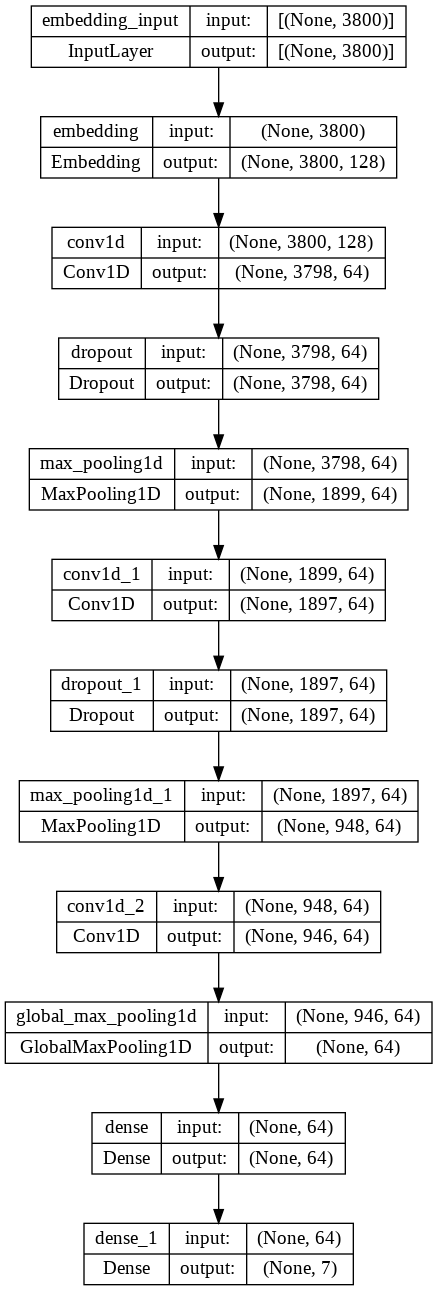

In [ ]:
# reference - https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
# print the cnn base model
plot_model(model_cnn, to_file='model_plot_cnn.png', show_shapes=True, show_layer_names=True)
# note - the code is been adapted from the reference and it is modified.

In [ ]:
# reference - https://analyticsindiamag.com/guide-to-text-classification-using-textcnn/
# reference - https://www.youtube.com/watch?v=8YsZXTpFRO0
# reference - https://www.analyticsvidhya.com/blog/2021/12/intent-classification-with-convolutional-neural-networks/
model_cnn.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
cnn_start_time = time.time()
model_cnn_history = model_cnn.fit(x_train_cnn, y_train_cnn,
                     epochs=5,
                     verbose=False,
                     validation_split=0.1,
                     batch_size=20,callbacks=[EarlyStopping(patience=15)])
cnn_stop_time = time.time()
# note - the code is been adapted from the references and it is modified
# note - the parameters of the models are randomly chosen


In [ ]:
 # training loss and training accuracy of the cnn base model
 # reference - https://realpython.com/python-keras-text-classification/
 loss, accuracy = model_cnn.evaluate(x_train_cnn, y_train_cnn)
 # note - the code is been adapted from the references and it is modified


20578/20578 [==============================] - 71s 3ms/step - loss: 0.2100 - accuracy: 0.9350


In [ ]:
# reference - https://plotly.com/python/line-and-scatter/
# reference - https://plotly.com/python/reference/layout/
# reference - https://www.kaggle.com/code/sercanyesiloz/plotly-tutorial/notebook#Line%20Charts
# reference - https://linuxhint.com/plotly-graph-objects-scatter/
# # plotting the training loss
cnn_model_training_loss = model_cnn_history.history['loss']
epochs = [1,2,3,4,5]
df_model_cnn_history = go.Scatter(x = epochs,
                     y = cnn_model_training_loss ,
                     mode="markers+lines",
                     marker = dict(color = 'red'))
cnn_layout = go.Layout(title={'text' : 'CNN MODEL TRAINING LOSS'},xaxis=dict(title = 'EPOCHS'),yaxis=dict(title='TRAINING LOSS'),
                   template = 'plotly_dark')


fig = go.Figure(data = df_model_cnn_history,layout=cnn_layout)
fig.update_layout(width=500,
    height=500
)
iplot(fig)
# note - the code is been adapted from the references and it is modified

In [ ]:
# reference - https://plotly.com/python/line-and-scatter/
# reference - https://plotly.com/python/reference/layout/
# reference - https://www.kaggle.com/code/sercanyesiloz/plotly-tutorial/notebook#Line%20Charts
# reference - https://linuxhint.com/plotly-graph-objects-scatter/
# # plotting the training accuracy
cnn_model_training_accuracy = model_cnn_history.history['accuracy']
epochs = [1,2,3,4,5]
df_model_cnn_history = go.Scatter(x = epochs,
                     y = cnn_model_training_accuracy ,
                     mode="markers+lines",
                     marker = dict(color = 'limegreen'))
cnn_layout = go.Layout(title={'text' : 'CNN MODEL TRAINING ACCURACY'},xaxis=dict(title = 'EPOCHS'),yaxis=dict(title='TRAINING ACCURACY'),
                   template = 'plotly_dark')

fig = go.Figure(data = df_model_cnn_history,layout=cnn_layout)
fig.update_layout(width=500,
    height=500
)
iplot(fig)
# note - the code is been adapted from the references and it is modified



In [ ]:
# predict the cnn base model
cnn_train_predict = model_cnn.predict(x_train_cnn)

20578/20578 [==============================] - 48s 2ms/step


In [ ]:
# reference - https://datascience.stackexchange.com/questions/93751/valueerror-classification-metrics-cant-handle-a-mix-of-multilabel-indicator-an
y_train_cnn_arg=np.argmax(y_train_cnn,axis=1)
y_train_pred_cnn = np.argmax(cnn_train_predict,axis=1)
# note - the code is been adapted from the references and it is modified
# note - I added this code because I was getting the value error of mix multilabel

### Training side of cnn model : getting precision,recall,f1,fbeta,mae,mse,rmse,training time

In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# generating the classification report
from sklearn import metrics
print(metrics.classification_report(y_train_cnn_arg, y_train_pred_cnn))
# note - the code is been adapted from the reference and it is modified

              precision    recall  f1-score   support

           0       0.91      0.94      0.92    184194
           1       0.95      0.87      0.90    145217
           3       0.71      0.37      0.48      3756
           4       0.83      0.85      0.84     40210
           6       0.97      0.98      0.98    285107

    accuracy                           0.93    658484
   macro avg       0.87      0.80      0.83    658484
weighted avg       0.93      0.93      0.93    658484



In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# calculate the accuracy
print(metrics.accuracy_score(y_train_cnn_arg, y_train_pred_cnn))
# note - the code is been adapted from the references and it is modified

0.9349779189775302


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
# calculate the precision score
print(precision_score(y_train_cnn_arg, y_train_pred_cnn,average='macro'))
# note - the code is been adapted from the references and it is modified

0.8706853388381128


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
# calculate the recall score
print(recall_score(y_train_cnn_arg, y_train_pred_cnn,average='macro'))
# note - the code is been adapted from the references and it is modified

0.8030307276630015


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# calculate the f1 score
print(f1_score(y_train_cnn_arg, y_train_pred_cnn,average='macro'))
# note - the code is been adapted from the references and it is modified

0.825661691040743


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html
# calculate the fbeta score
print(fbeta_score(y_train_cnn_arg, y_train_pred_cnn,average='macro', beta = 0.7))
# note - the code is been adapted from the references and it is modified

0.8374020632689009


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
# calculate the MAE
print(mean_absolute_error(y_train_cnn_arg, y_train_pred_cnn))
# note - the code is been adapted from the references and it is modified

0.20993220792001022


In [ ]:
# calculate the MSE
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print(mean_squared_error(y_train_cnn_arg, y_train_pred_cnn,squared=True))
# note - the code is been adapted from the references and it is modified

0.906760073137692


In [ ]:
# calculate the RMSE
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print(mean_squared_error(y_train_cnn_arg, y_train_pred_cnn,squared=False))
# note - the code is been adapted from the references and it is modified

0.9522395040837636


In [ ]:
# calculate the train time
training_time_cnn = cnn_stop_time - cnn_start_time
training_time_cnn

877.7572619915009

### Testing side of mlp model : getting precision,recall,f1,fbeta,mae,mse,rmse

In [ ]:
# predict the cnn base model
cnn_predict = model_cnn.predict(x_test_cnn)

5145/5145 [==============================] - 12s 2ms/step


In [ ]:
# reference - https://datascience.stackexchange.com/questions/93751/valueerror-classification-metrics-cant-handle-a-mix-of-multilabel-indicator-an
y_test_cnn_arg=np.argmax(y_test_cnn,axis=1)
y_pred_cnn = np.argmax(cnn_predict,axis=1)
# note - the code is been adapted from the references and it is modified
# note - I added this code because I was getting the value error of mix multilabel

In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# generating the classification report
from sklearn import metrics
print(metrics.classification_report(y_test_cnn_arg, y_pred_cnn))
# note - the code is been adapted from the references and it is modified

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.95      0.80      0.86    119609
           2       0.00      0.00      0.00      7281
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00     37731
           6       0.00      0.00      0.00         0

    accuracy                           0.58    164621
   macro avg       0.14      0.11      0.12    164621
weighted avg       0.69      0.58      0.63    164621



In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# calculate the accuracy
print(metrics.accuracy_score(y_test_cnn_arg, y_pred_cnn))
# note - the code is been adapted from the references and it is modified

0.5785349378268873


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
# calculate the precision score
print(precision_score(y_test_cnn_arg, y_pred_cnn,average='macro'))
# note - the code is been adapted from the references and it is modified

0.13502144997887608


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
# calculate the recall score
print(recall_score(y_test_cnn_arg, y_pred_cnn,average='macro'))
# note - the code is been adapted from the references and it is modified

0.11375039862026627


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# calculate the f1 score
print(f1_score(y_test_cnn_arg, y_pred_cnn,average='macro'))
# note - the code is been adapted from the references and it is modified

0.12347654160926991


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html
# calculate the fbeta score
print(fbeta_score(y_test_cnn_arg, y_pred_cnn,average='macro', beta = 0.7))
# note - the code is been adapted from the references and it is modified

0.1271992249481672


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
# calculate the MAE
print(mean_absolute_error(y_test_cnn_arg, y_pred_cnn))
# note - the code is been adapted from the references and it is modified

1.4004227893160655


In [ ]:
# calculate the MSE
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print(mean_squared_error(y_test_cnn_arg, y_pred_cnn,squared=True))
# note - the code is been adapted from the references and it is modified

6.017172778685587


In [ ]:
# calculate the RMSE
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print(mean_squared_error(y_test_cnn_arg, y_pred_cnn,squared=False))
# note - the code is been adapted from the references and it is modified

2.452992616924394


## CNN Tuned Model

In [ ]:
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tune
# reference - https://stackoverflow.com/questions/60868089/fine-tuning-cnn-hyperparameters-for-complex-text-classification
# reference - https://www.youtube.com/watch?v=OzLAdpqm35E&t=704s
# define the model for the hyperparameters
def create_model(hyper_para):
  cnn_model_tuned = keras.Sequential()
  cnn_model_tuned.add(layers.Embedding(input_dim = hyper_para.Int('input_dim', min_value = 15000,max_value = 20000 , step = 5000 ),output_dim = hyper_para.Int('output_dim',min_value=100,max_value=200,step = 100),input_length = 3800))
  cnn_model_tuned.add(layers.Convolution1D(filters = hyper_para.Int('filters',min_value = 128, max_value = 256, step = 128),kernel_size=hyper_para.Int('kernel_size',min_value=3,max_value=5, step = 2),padding = 'same', activation = 'relu'))
  cnn_model_tuned.add(Dropout(0.1))
  cnn_model_tuned.add(MaxPooling1D())
  cnn_model_tuned.add(layers.Convolution1D(filters = hyper_para.Int('filters',min_value = 128, max_value = 256, step = 128),kernel_size=hyper_para.Int('kernel_size',min_value=3,max_value=5, step = 2),padding = 'same', activation = 'relu'))
  cnn_model_tuned.add(Dropout(0.2))
  cnn_model_tuned.add(MaxPooling1D())
  cnn_model_tuned.add(layers.Convolution1D(filters = hyper_para.Int('filters',min_value = 128, max_value = 256, step = 128),kernel_size=hyper_para.Int('kernel_size',min_value=3,max_value=5, step = 2),padding = 'same', activation = 'relu'))
  cnn_model_tuned.add(layers.GlobalMaxPooling1D())
  cnn_model_tuned.add(layers.Dense(units=hyper_para.Int('units',min_value = 128, max_value = 256, step = 128),activation = 'relu'))
  cnn_model_tuned.add(layers.Dense(7, activation='softmax'))
  cnn_model_tuned.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(hyper_para.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])),metrics=['accuracy'])
  return cnn_model_tuned
# note - the code is been adapted from the references and it is modified


### CNN tuning with hyperband

In [ ]:
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tune
# referencesc - https://keras.io/api/keras_tuner/tuners/hyperband/
# reference - https://www.youtube.com/watch?v=6Nf1x7qThR8&t=444s
from kerastuner.tuners import Hyperband
cnn_hyperband_tuner = Hyperband(
    create_model,
    max_epochs= 2,
    hyperband_iterations=1,
    overwrite = True,
    objective = 'accuracy',
    factor = 2
)
cnn_hyperband_tuner.search_space_summary()
# note - the code is been adapted from the references and it is modified

Search space summary
Default search space size: 6
input_dim (Int)
{'default': None, 'conditions': [], 'min_value': 15000, 'max_value': 20000, 'step': 5000, 'sampling': None}
output_dim (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 200, 'step': 100, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 128, 'sampling': None}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 2, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 128, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
# reference - https://www.youtube.com/watch?v=6Nf1x7qThR8&t=444s
# create the earlystopping
early_stop_cnn = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy',patience=100)
# note - the code is been adapted from the references and it is modified

In [ ]:
# reference - https://www.youtube.com/watch?v=6Nf1x7qThR8&t=444s
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tune
# reference - https://keras.io/api/keras_tuner/tuners/hyperband/
# searching for best hyperparameters
cnn_hyperband_tuner.search(x_train_cnn, y_train_cnn, epochs=2, validation_split=0.1, callbacks=[early_stop_cnn],batch_size=512)
# note - the code is been adapted from the references and it is modified
# note - parameters are randomly chosen

Trial 5 Complete [00h 04m 57s]
accuracy: 0.9119306206703186

Best accuracy So Far: 0.9127169251441956
Total elapsed time: 00h 22m 35s


In [ ]:
# reference - https://www.youtube.com/watch?v=6Nf1x7qThR8&t=444s
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
# best hyperparameters
best_hyperparameters_cnn = cnn_hyperband_tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters_cnn.values
# note - the code is been adapted from the references and it is modified

{'input_dim': 20000,
 'output_dim': 200,
 'filters': 256,
 'kernel_size': 5,
 'units': 128,
 'learning_rate': 0.01,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [ ]:
# creating 1st cnn model(epochs=10 and batch_size=512) with best hyperparameters
# reference - https://www.youtube.com/watch?v=6Nf1x7qThR8&t=444s
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
model_cnn_tuned1 = cnn_hyperband_tuner.hypermodel.build(best_hyperparameters_cnn)
model_cnn_tuned1_history = model_cnn_tuned1.fit(x_train_cnn, y_train_cnn,validation_split=0.1,
                     epochs=10,
                     verbose=False,
                     batch_size=512,callbacks=[EarlyStopping(monitor = 'accuracy',patience=100)])
# note - the code is been adapted from the references and it is modified
# note the values of epochs and batch size are chosen randomly

In [ ]:
# training loss and training accuracy of the 1st tuned cnn model
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
loss, accuracy = model_cnn_tuned1.evaluate(x_train_cnn, y_train_cnn)
# note - the code is been adapted from the reference and it is modified

20578/20578 [==============================] - 132s 6ms/step - loss: 0.1970 - accuracy: 0.9409


In [ ]:
# testing loss and testing accuracy of the 1st tuned cnn model
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
loss, accuracy = model_cnn_tuned1.evaluate(x_test_cnn, y_test_cnn)
# note - the code is been adapted from the reference and it is modified

5145/5145 [==============================] - 33s 6ms/step - loss: 20.2291 - accuracy: 0.5539


In [ ]:
# creating 2nd cnn model(epochs=15 and batch_size=512) with best hyperparameters
# reference - https://www.youtube.com/watch?v=6Nf1x7qThR8&t=444s
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
model_cnn_tuned2 = cnn_hyperband_tuner.hypermodel.build(best_hyperparameters_cnn)
model_cnn_tuned2_history = model_cnn_tuned2.fit(x_train_cnn, y_train_cnn,validation_split = 0.1,
                     epochs=15,
                     verbose=False,
                     batch_size=512,callbacks=[EarlyStopping(monitor = 'accuracy',patience=100)])
# note - the code is been adapted from the references and it is modified
# note the values of epochs and batch size are chosen randomly

In [ ]:
# training loss and training accuracy of the 2nd tuned cnn model
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
loss, accuracy = model_cnn_tuned2.evaluate(x_train_cnn, y_train_cnn)
# note - the code is been adapted from the reference and it is modified

20578/20578 [==============================] - 132s 6ms/step - loss: 0.1777 - accuracy: 0.9517


In [ ]:
# testing loss and testing accuracy of the 2nd tuned cnn model
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
loss, accuracy = model_cnn_tuned2.evaluate(x_test_cnn, y_test_cnn)
# note - the code is been adapted from the reference and it is modified

5145/5145 [==============================] - 33s 6ms/step - loss: 25.9194 - accuracy: 0.5390


### CNN tuning with random search

In [ ]:
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
# reference - https://keras.io/api/keras_tuner/tuners/random/
from kerastuner.tuners import RandomSearch
cnn_randomsearch_tuner = RandomSearch(
    create_model,
    max_trials=3,
    objective='accuracy',
)
cnn_randomsearch_tuner.search_space_summary()
# note - the code is been adapted from the reference and it is modified

Search space summary
Default search space size: 6
input_dim (Int)
{'default': None, 'conditions': [], 'min_value': 15000, 'max_value': 20000, 'step': 5000, 'sampling': None}
output_dim (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 200, 'step': 100, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 128, 'sampling': None}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 2, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 128, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
# reference - https://www.youtube.com/watch?v=6Nf1x7qThR8&t=444s
# create the earlystopping
early_stop_cnn1 = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy',patience=100)
# note - the code is been adapted from the reference and it is modified

In [ ]:
# reference - https://www.youtube.com/watch?v=6Nf1x7qThR8&t=444s
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tune
# reference - https://keras.io/api/keras_tuner/tuners/hyperband/
# searching for best hyperparameters
cnn_randomsearch_tuner.search(x_train_cnn, y_train_cnn, epochs=2, validation_split=0.1, callbacks=[early_stop_cnn1],batch_size=512)
# note - the code is been adapted from the references and it is modified
# note - parameters are randomly chosen

In [ ]:
# reference - https://www.youtube.com/watch?v=6Nf1x7qThR8&t=444s
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
# best hyperparameters
best_hyperparameters_cnn1 = cnn_randomsearch_tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters_cnn1.values
# note - the code is been adapted from the references and it is modified

{'input_dim': 20000,
 'output_dim': 200,
 'filters': 256,
 'kernel_size': 5,
 'units': 128,
 'learning_rate': 0.01,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [ ]:
# creating 3rd cnn model(epochs=10 and batch_size=512) with best hyperparameters
# reference - # reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
# reference - https://www.youtube.com/watch?v=6Nf1x7qThR8&t=444s
model_cnn_tuned3 = cnn_randomsearch_tuner.hypermodel.build(best_hyperparameters_cnn1)
model_cnn_tuned3_history = model_cnn_tuned3.fit(x_train_cnn, y_train_cnn,validation_split=0.1,
                     epochs=10,
                     verbose=False,
                     batch_size=512,callbacks=[EarlyStopping(monitor = 'accuracy',patience=100)])
# note - the code is been adapted from the references and it is modified
# note the values of epochs and batch size are chosen randomly

In [ ]:
# training loss and training accuracy of the 3rd tuned cnn model
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
loss, accuracy = model_cnn_tuned3.evaluate(x_train_cnn, y_train_cnn)
# note - the code is been adapted from the reference and it is modified

20578/20578 [==============================] - 132s 6ms/step - loss: 1.2777 - accuracy: 0.4330


In [ ]:
# testing loss and testing accuracy of the 3rd tuned cnn model
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
loss, accuracy = model_cnn_tuned3.evaluate(x_test_cnn, y_test_cnn)
# note - the code is been adapted from the reference and it is modified

5145/5145 [==============================] - 33s 6ms/step - loss: 7.7737 - accuracy: 0.0000e+00


In [ ]:
# creating 4th cnn model(epochs=15 and batch_size=512) with best hyperparameters
# reference - # reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
# reference - https://www.youtube.com/watch?v=6Nf1x7qThR8&t=444s
model_cnn_tuned4 = cnn_randomsearch_tuner.hypermodel.build(best_hyperparameters_cnn1)
model_cnn_tuned4_history = model_cnn_tuned4.fit(x_train_cnn, y_train_cnn,validation_split=0.1,
                     epochs=15,
                     verbose=False,
                     batch_size=512,callbacks=[EarlyStopping(monitor = 'accuracy',patience=100)])
# note - the code is been adapted from the references and it is modified
# note the values of epochs and batch size are chosen randomly

In [ ]:
# training loss and training accuracy of the 4th tuned cnn model
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
loss, accuracy = model_cnn_tuned4.evaluate(x_train_cnn, y_train_cnn)
# note - the code is been adapted from the reference and it is modified

20578/20578 [==============================] - 133s 6ms/step - loss: 0.3544 - accuracy: 0.9011


In [ ]:
# testing loss and testing accuracy of the 4th tuned cnn model
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
loss, accuracy = model_cnn_tuned4.evaluate(x_test_cnn, y_test_cnn)
# note - the code is been adapted from the reference and it is modified

5145/5145 [==============================] - 33s 6ms/step - loss: 27.4857 - accuracy: 0.5957
